### State Space Modeling
The model that we consider is the following 
\begin{equation}
\dot{\underline{x}}_{1-6} = \mathbf{\underline{A}} \underline{x}_{1-6} + \mathbf{\underline{B}} u + \mathbf{\underline{F}} z
\end{equation}

where $\mathbf{\underline{A}}$ is the system matrix, $\mathbf{\underline{B}}$ is the control matrix and $\mathbf{\underline{F}}$ is the disturbance matrix. Also, $\underline{x}$ is the state vector, $\underline{u}$ is the control vector, $\underline{z}$ is the disturbance vector. To make the state states are decoupled, the matrices $\mathbf{\underline{A}}$ and $\mathbf{\underline{B}}$ should be diagonal matrices. There are many approaches to make it decouple, one of the approaches is using the transformation matrix $\mathbf{\underline{T}}$.

\begin{equation}
\dot{\underline{x}}_{7-12} = \underline{u} \odot \underline{x}_{1-6}
\end{equation}

\begin{equation}
\underline{y} = \mathbf{\underline{C}} \underline{x}_{1-6}
\end{equation}


After we apply this transformation, the system becomes

\begin{equation}
\dot{\tilde{\underline{x}}}_{1-6} = \tilde{\mathbf{\underline{A}}} \tilde{\underline{x}}_{1-6} + \tilde{\mathbf{\underline{B}}} \tilde{u} + \tilde{\mathbf{\underline{F}}} \tilde{z} 
\end{equation}

\begin{equation}
\dot{\underline{x}}_{7-12} = \mathbf{T}^\top \underline{\tilde{u}} \odot \mathbf{T}^\top \tilde{\underline{x}}_{1-6}
\end{equation}

\begin{equation}
\tilde{\underline{y}} = \tilde{\mathbf{\underline{C}}} \tilde{\underline{x}}_{1-6}
\end{equation}

After we get the transformed values for $\tilde{\underline{y}}$, by using the following relation we get the untransformed values for $\underline{y}$, as desired.

\begin{equation}
\tilde{\underline{y}} = \mathbf{T}\mathbf{C}^\top\underline{y}
\end{equation}


\begin{equation}
\begin{array}{cc} 
\underline{y}
\end{array}
= \left(\begin{array}{c} 
-\tilde{x_{5}}-\frac{1}{\sqrt{3}} \tilde{x_{6}}\\
\tilde{x_{5}}-\frac{1}{\sqrt{3}} \tilde{x_{6}}\\ 
\frac{2}{\sqrt{3}} \tilde{x_{6}}\\
\end{array}\right)  
\end{equation}


To find the initial conditions for $x_{1:6}$, we are using the function of $y_{ref}$ at time $t=0$. Then we have the following linear system 

\begin{equation}
\left(\begin{array}{cc} 
y_{1,ref}(0) \\
y_{2,ref}(0) \\
y_{3,ref}(0) \\
\end{array}\right)
= \left(\begin{array}{c} 
0 & 0 & 0 & 0 & -1 & \frac{1}{\sqrt{3}}\\
0 & 0 & 0 & 0 & -1 &  \frac{-1}{\sqrt{3}}\\ 
0 & 0 & 0 & 0 & 0 & \frac{2}{\sqrt{3}} \\
\end{array}\right)     
\left(\begin{array}{c} 
\tilde{x_{1}}(0)\\
\tilde{x_{2}}(0)\\ 
\tilde{x_{3}}(0)\\
\tilde{x_{4}}(0)\\
\tilde{x_{5}}(0)\\
\tilde{x_{6}}(0)\\
\end{array}\right) 
\end{equation}

where $$y_{\text{k, ref}} = \hat{I}_{\text{AC}} \cdot \cos\left( \omega_{\text{AC}} t - \frac{2 \pi (k - 1)}{3} - \varphi_{\text{AC}} \right)$$
with $k={1,2,3}$, $\hat{I}_{\text{AC}} = 15$, $\varphi_{\text{AC}}=0$ and $ \omega_{\text{AC}} = 2\pi50$

For use in .ipy file
parser = argparse.ArgumentParser(description="Model output")
parser.add_argument("url",metavar="url",type=str,
                    help= "The URL on which the model is running, e.g. http://localhost:[port_number] if the model is hosted locally")
args = parser.parse_args()
print(f"Connecting to host {args.url}")

### Define Variables

In [5]:
import umbridge
import numpy as np#
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference solution for the output currents i_1...i_3, i.e. y_1...y_3
def y_reference(t,I_AC,omega_AC):
    y = []
    for k in range(3):
        y.append(I_AC*np.cos(omega_AC*t-2*np.pi*(k-1)/3))
    return np.array(y)

# T matrix 
T = np.array( [[1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [-1/np.sqrt(6), -1/np.sqrt(6), -1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [1/2, -1/2, 0, -1/2, 1/2, 0],
                      [1/np.sqrt(12), 1/np.sqrt(12), -1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                      [-1/2, 1/2, 0, -1/2, 1/2, 0],
                      [-1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                     ])

# Define the input parameters according to the nominal values given in the version 3 of the paper
R_arm = 20e-3   # 20 mΩ, will vary in a 10 percent range
R_DC = 10e-3      # 10 mΩ, fix so it will not vary
R_AC = 60e-3    # 60 mΩ, will vary in a 10 percent range
L_arm = 200e-6  # 200 µH, will vary in a 10 percent range
L_DC = 5e-3      # 5 mH, fix so it will not vary
L_AC = 320e-3   # 320 mH, will vary in a 10 percent range

#u_parameters =  [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]  # Values within the voltage constraint (<= 800V)
omega_AC = 2*np.pi*50  # Example angular frequency (50 Hz)
I_AC = 15
U_AC = 700
U_DC = 325

#Define inital values for the parameters of the control vector u
u0 = [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]
#p_initial = np.array([599.3/2,0,0,599.3/2,0,
#             23.3/2,0,0,23.3/2,0,
#             427.5/2,0,0,427.5/2,0,
#             100.7/2,0,0,100.7/2,0,
#             676.7/2,0,0,676.7/2,0,
#             272.5/2,0,0,272.5/2,0])
#p_initial = [0,0,0,0,350,330,50,23.3/2,0,50,0,23.3/2,50,0,427.5/2,0,50,0,427.5/2,50,0,100.7/2,0,50,0,100.7/2,50,0,676.7/2,0,50,0,676.7/2,50,0,272.5/2,0,50,0,272.5/2,50,0]
p_initial = np.ones(30)

#Define inital values for x_tilde
A = np.array([[0,0,0,0,-1,-1/np.sqrt(3)],
             [0,0,0,0,1,-1/np.sqrt(3)],
             [0,0,0,0,0,2/np.sqrt(3)]])
b_ = y_reference(0,I_AC,omega_AC)
# Use least squares to solve Ax = b
x_tilde0, residuals, rank, singular_values = np.linalg.lstsq(A, b_, rcond=None)


# Create the parameters list
#parameters = [[R_arm, R_DC, R_AC, L_arm, L_DC, L_AC], list(p_initial), [omega_AC,U_AC,U_DC],list(x_tilde0)]

### Optimisation Procedure

In [2]:
# Initialize the model
model = umbridge.HTTPModel("http://localhost:4242", "MMC_Solver")

# Initialize reference vector
t_eval = np.arange(0,20e-3+125e-6,125e-6)
y_ref = np.array([y_reference(t,I_AC=I_AC,omega_AC=omega_AC) for t in t_eval])

#Define objective function, e.g. a mse inspired loss 
def objective_function(p, x_tilde0, R_arm, R_DC, R_AC, L_arm, L_DC, L_AC,omega_AC, U_AC, U_DC,y_ref):
    """
    Calculate the MSE between the actual output of the MMC and the desired y_ref
    """
    parameters = [[R_arm, R_DC, R_AC, L_arm, L_DC, L_AC], list(p), [omega_AC,U_AC,U_DC],list(x_tilde0)]
    model_output = model(parameters)
    y_model = np.array(model_output[0][0])
    
    mse = np.mean((y_model.T-y_ref)**2)
    return mse

#### Implement Constraints

In [3]:
def constraint_arm_power(p,x_tilde0,R_arm, R_DC, R_AC, L_arm, L_DC, L_AC,omega_AC,U_AC,U_DC,upper_bound):
    """
    Define constraint on arm powers, i.e. derivatives of x_7...x_12. That is, they must not exceed 5 kW
    """
    parameters = [[R_arm, R_DC, R_AC, L_arm, L_DC, L_AC], list(p), [omega_AC,U_AC,U_DC],list(x_tilde0)]
    model_output = model(parameters)

    #Get arm powers 
    arm_powers = np.array(model_output[2])

    #Enforce that x_tilde_power is within the specified bounds
    ineq = upper_bound-np.abs(arm_powers)

    return ineq.flatten()

def constraint_control_vector(p,t_eval,bound):
    u = np.array([control_vector(t,p) for t in t_eval])
    
    ineq = bound - np.abs(u)
    return ineq.flatten()

#Define upper bounds for constraints
arm_powers_upper_bound = 5e3 #in W
control_vector_bound = 800 #in V

#Define constraints
constraints = [{"type": "ineq","fun": constraint_control_vector, "args":(t_eval,control_vector_bound)},
               {"type": "ineq","fun": constraint_arm_power,"args":(x_tilde0,R_arm, R_DC, R_AC, L_arm, L_DC, L_AC,U_AC,U_DC,arm_powers_upper_bound)}]


In [3]:
# Perform optimization to minimize the objective function
p_result = minimize(objective_function, x0=p_initial, args=(x_tilde0, R_arm, R_DC, R_AC, L_arm, L_DC, L_AC,omega_AC, U_AC, U_DC,y_ref),method='SLSQP')


### Plot results

#### Plot output y of MMC

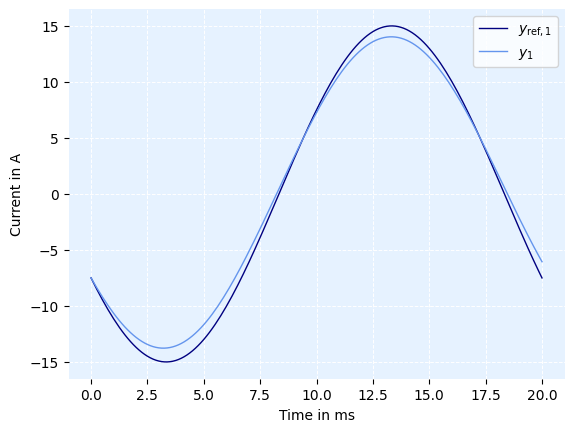

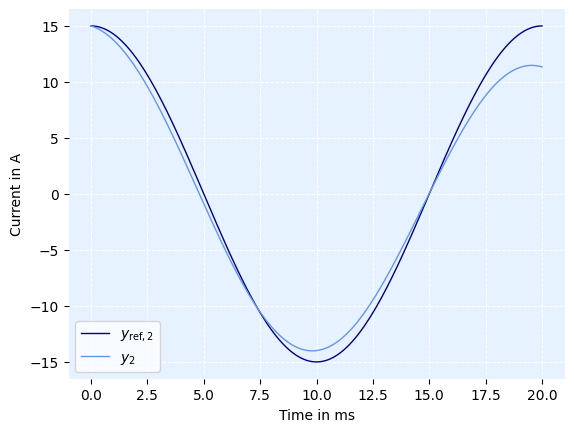

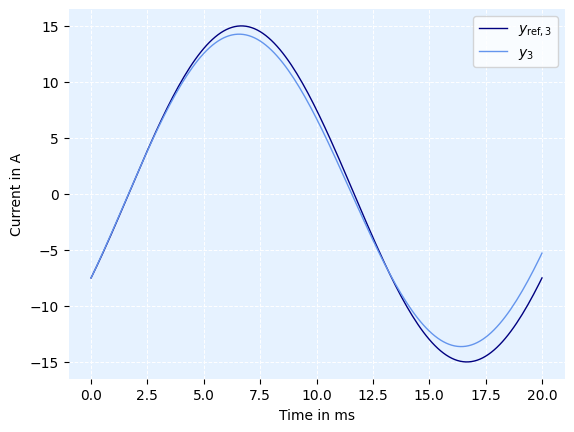

In [6]:
#save optimised parameters
p_optimised = p_result.x
#print(p_optimised)

#Compare y calculated with control vector with optimised parameters to y_ref
parameters = [[R_arm, R_DC, R_AC, L_arm, L_DC, L_AC], list(p_optimised), [omega_AC,U_AC,U_DC],list(x_tilde0)]
model_output = model(parameters)
y_model_optimised = np.array(model_output[0][0])

#Plot solution
for i in range(3):
    fig,ax = plt.subplots()
    ax.plot(t_eval*1e3,[y_reference(t,I_AC=I_AC,omega_AC=omega_AC)[i] for t in t_eval],color="navy",linewidth=1,label=r"$y_{{\text{{ref}},{}}}$".format(i+1))
    ax.plot(t_eval*1e3,y_model_optimised[i],color="cornflowerblue",linewidth=1,label=r"$y_{}$".format(i+1))

    ax.legend()

    # Optionally add axis labels and a title
    ax.set_xlabel('Time in ms')  # Replace with your actual x-axis label
    ax.set_ylabel('Current in A')  # Replace with your actual y-axis label

    ax.set_facecolor('#e6f2ff') 
    ax.grid(True, color='white', linestyle='--', linewidth=0.7)  # Lighter grid lines

    # Remove the outer boxes (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()
    plt.savefig(f".\y_{i}.png",dpi=300)
    plt.close()

#### Plot Control Vector $\underbar{u}(t)$ for optimised parameters

In [8]:
control_vector_optimised.shape

(161, 6)

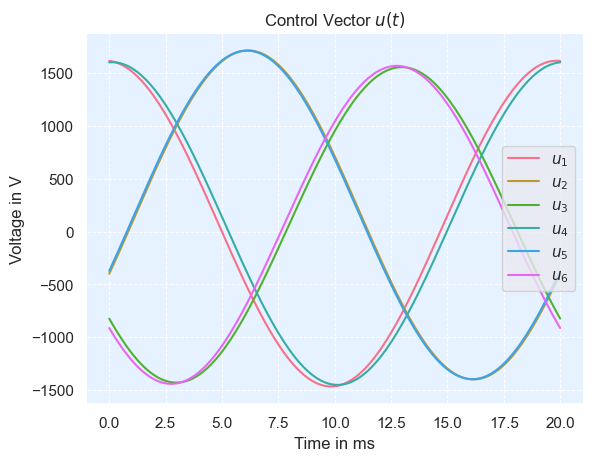

In [10]:
import seaborn as sns
sns.set_theme() 
# Define a color palette
colors = sns.color_palette("husl", 6) 

#Get control vector for optimised parameters
control_vector_optimised = np.array(model_output[1][0])
fig, ax = plt.subplots()  # Corrected this line to ensure ax is defined correctly
for i in range(6):
    # Using a list comprehension to get control vector values for plotting
    ax.plot(t_eval*1e3, control_vector_optimised.T[i], color=colors[i],label=r"$u_{}$".format(i+1))

ax.legend()

ticks = ax.get_xticks()  # Get current x ticks

#ax.ticklabel_format(axis="x",style="sci",scilimits=(0,0))

# Optionally add axis labels and a title
ax.set_xlabel('Time in ms')  # Replace with your actual x-axis label
ax.set_ylabel('Voltage in V')  # Replace with your actual y-axis label
ax.set_title(r'Control Vector $u(t)$')  # Replace with your actual title

ax.set_facecolor('#e6f2ff') 
ax.grid(True, color='white', linestyle='--', linewidth=0.7)  # Lighter grid lines
# Remove the outer boxes (spines)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()
plt.close()

#### Plot arm powers $\dot{x}_{7-12}$

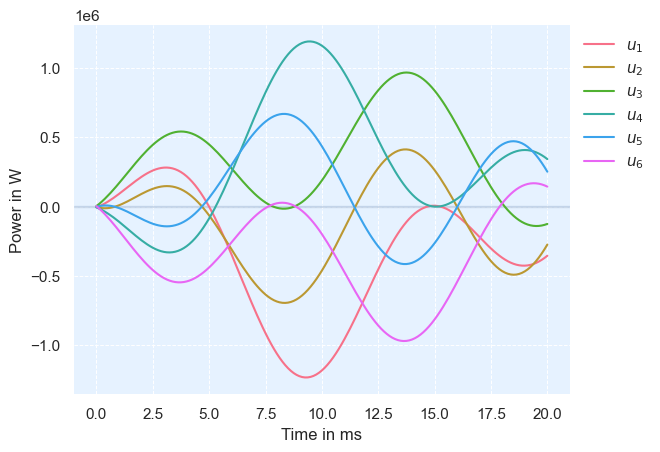

In [11]:
arm_powers_optimised = np.array(model_output[2][0])

#Plot the arm powers
fig, ax = plt.subplots()  # Corrected this line to ensure ax is defined correctly
for i in range(6):
    # Using a list comprehension to get control vector values for plotting
    ax.plot(t_eval*1e3, arm_powers_optimised[i], color=colors[i],label=r"$u_{}$".format(i+1))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Color a specific area in the background
ax.axhspan(-5e3, 5e3, color='lightsteelblue', alpha=0.5)

# Optionally add axis labels and a title
ax.set_xlabel('Time in ms')  # Replace with your actual x-axis label
ax.set_ylabel('Power in W')  # Replace with your actual y-axis label

ax.set_facecolor('#e6f2ff') 
ax.grid(True, color='white', linestyle='--', linewidth=0.7)  # Lighter grid lines
# Remove the outer boxes (spines)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()
plt.close()